<a href="https://colab.research.google.com/github/pacasarini/spark/blob/main/3_Spark_GraphX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Configurando o Spark ##

In [ ]:
!ls
!rm -rf *
#Instacao e configuracao do Java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Download do Apache Spark
!wget -q https://apache.osuosl.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz
#Descompatacao do Apache Spark
!tar xf spark-3.2.4-bin-hadoop3.2.tgz
#Instalacao do Findspark
!pip install -q findspark

people_graph_edge    spark-3.2.4-bin-hadoop3.2
people_graph_vertex  spark-3.2.4-bin-hadoop3.2.tgz


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.4-bin-hadoop3.2"

In [ ]:
!curl -L -o "/content/spark-3.2.4-bin-hadoop3.2/jars/graphframes-0.8.2-spark3.2-s_2.12.jar" https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  242k  100  242k    0     0   884k      0 --:--:-- --:--:-- --:--:--  886k


In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").config("spark.jars.packages", "graphframes:graphframes:0.7.0-spark2.4-s_2.11").getOrCreate()

In [ ]:
import pyspark
print(pyspark.__version__)

3.2.4


In [ ]:
from graphframes import *

vertices = spark.createDataFrame([
  (1, "Alice", 25),
  (2, "Bob", 30),
  (3, "Charlie", 35),
  (4, "David", 40),
  (5, "Eve", 45)
], ["id", "name", "age"])

edges = spark.createDataFrame([
  (1, 2, "lovers"),
  (1, 2, "friends"),
  (1, 3, "friends"),
  (1, 4, "friends"),
  (2, 3, "friends"),
  (3, 4, "friends"),
  (4, 5, "friends"),
  (5, 4, "advisor"),
  (5, 1, "friends"),
  (1, 5, "friends")
], ["src", "dst", "relationship"])

g = GraphFrame(vertices, edges)

In [ ]:
g.vertices.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  1|  Alice| 25|
|  2|    Bob| 30|
|  3|Charlie| 35|
|  4|  David| 40|
|  5|    Eve| 45|
+---+-------+---+



In [ ]:
g.edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  1|  2|      lovers|
|  1|  2|     friends|
|  1|  3|     friends|
|  1|  4|     friends|
|  2|  3|     friends|
|  3|  4|     friends|
|  4|  5|     friends|
|  5|  4|     advisor|
|  5|  1|     friends|
|  1|  5|     friends|
+---+---+------------+



In [ ]:
g.degrees.show()

+---+------+
| id|degree|
+---+------+
|  1|     6|
|  3|     3|
|  2|     3|
|  4|     4|
|  5|     4|
+---+------+



In [ ]:
g.inDegrees.show()

+---+--------+
| id|inDegree|
+---+--------+
|  3|       2|
|  2|       2|
|  4|       3|
|  5|       2|
|  1|       1|
+---+--------+



In [ ]:
g.outDegrees.show()

+---+---------+
| id|outDegree|
+---+---------+
|  1|        5|
|  2|        1|
|  5|        2|
|  3|        1|
|  4|        1|
+---+---------+



In [ ]:
g.pageRank(maxIter=10).vertices.show()

+---+-------+---+------------------+
| id|   name|age|          pagerank|
+---+-------+---+------------------+
|  1|  Alice| 25|0.8216418845898458|
|  2|    Bob| 30|0.4293408370632039|
|  3|Charlie| 35|0.6555740271189773|
|  4|  David| 40|1.5151096490823202|
|  5|    Eve| 45| 1.578333602145653|
+---+-------+---+------------------+



In [ ]:
g.shortestPaths(landmarks = ['5']).show()

+---+-------+---+---------+
| id|   name|age|distances|
+---+-------+---+---------+
|  1|  Alice| 25| {5 -> 1}|
|  2|    Bob| 30| {5 -> 3}|
|  3|Charlie| 35| {5 -> 2}|
|  4|  David| 40| {5 -> 1}|
|  5|    Eve| 45| {5 -> 0}|
+---+-------+---+---------+



In [ ]:
import networkx as nx

def plot_graph(es):
    g = nx.DiGraph()
    for row in es.select('src','dst').collect():
        g.add_edge(row['src'],row['dst'])

    nx.draw(g, with_labels=True, node_color='yellow')

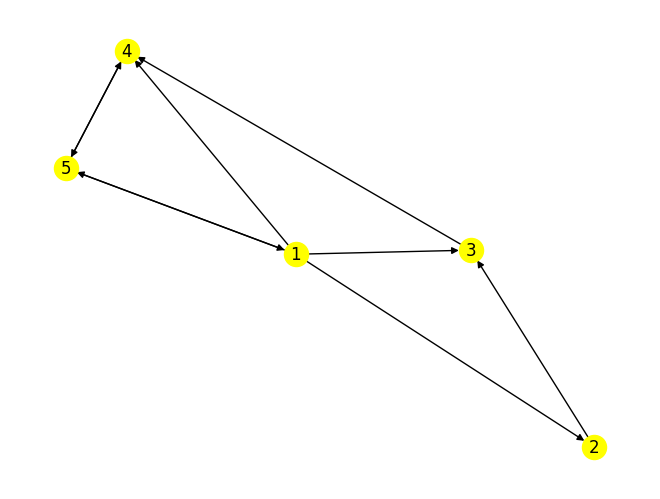

In [ ]:
plot_graph(g.edges)

In [ ]:
def save_graph(path, graph):
    """For illustration only - clobbers existing file."""
    vfile = f'{path}_vertex'
    efile = f'{path}_edge'
    graph.vertices.write.mode('overwrite').parquet(vfile)
    graph.edges.write.mode('overwrite').parquet(efile)

def load_graph(path):
    vfile = f'{path}_vertex'
    efile = f'{path}_edge'
    v = spark.read.parquet(vfile)
    e = spark.read.parquet(efile)
    return GraphFrame(v, e)

In [ ]:
save_graph('people_graph', g)

In [ ]:
g1 = load_graph('people_graph')

In [ ]:
g1.vertices.count()

5

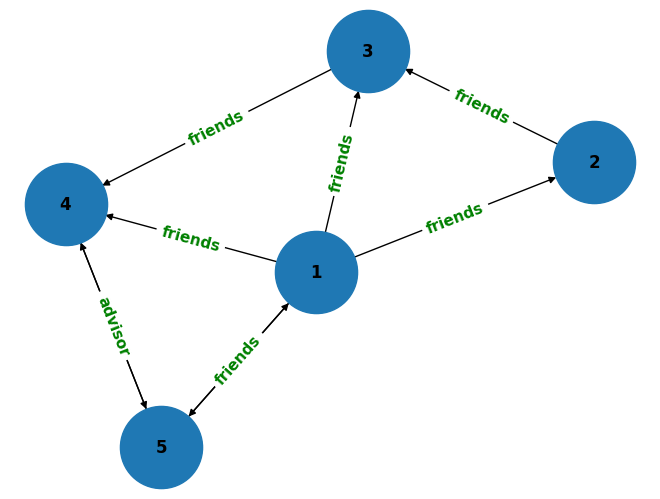

In [ ]:
# the function will plot the source and destination nodes and connect them by meand of undirected line
def plot_directed_graph(edge_list):
    gplot=nx.DiGraph()
    edge_labels = {}
    for row in edge_list.select("src", "dst", "relationship").take(1000):
        gplot.add_edge(row["src"], row["dst"])
        edge_labels[(row["src"], row["dst"])] = row["relationship"]
    pos = nx.spring_layout(gplot)
    nx.draw(gplot, pos, with_labels=True, font_weight="bold", node_size=3500)
    nx.draw_networkx_edge_labels(gplot, pos, edge_labels=edge_labels, font_color="green", font_size=11, font_weight="bold")
plot_directed_graph(g.edges)

In [ ]:
g1.edges.filter("relationship = 'advisor'").count()

1

In [ ]:
g.labelPropagation(maxIter=4).show()

+---+-------+---+-----+
| id|   name|age|label|
+---+-------+---+-----+
|  1|  Alice| 25|    2|
|  2|    Bob| 30|    2|
|  3|Charlie| 35|    2|
|  4|  David| 40|    2|
|  5|    Eve| 45|    2|
+---+-------+---+-----+

